# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier



## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test   = test['features'], test['labels']

## Step 1: Dataset Summary & Exploration

### Provide a Basic Summary of the Data

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

n_train = y_train.shape[0]

n_validation = y_valid.shape[0]

n_test = y_test.shape[0]

image_shape = X_train[0].shape

n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

Label: 2 | Index (in the training set) 32820


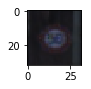

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
index = 0

# Let's have a look at an example of 50kph speed limit sign
while y_train[index] != 2:
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print("Label:", y_train[index], "| Index (in the training set)", index)

Let's visualize the distribution of each traffic sign in the 3 different data sets.

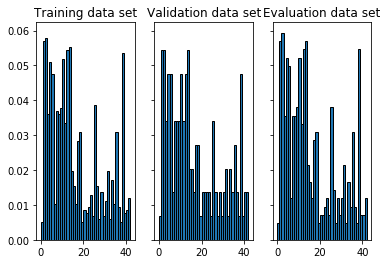

In [4]:
bins = range(n_classes)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True)

ax1.hist(y_train, bins, normed=True, ec='black')
ax1.set_title('Training data set')

ax2.hist(y_valid, bins, normed=True, ec='black')
ax2.set_title('Validation data set')

ax3.hist(y_test, bins, normed=True, ec='black')
ax3.set_title('Evaluation data set')

plt.show()

We can see that some traffic signs are much more frequent than others (for instance the max speed 20 kph is 10 times less present than the very common 30 kph speed limit sign. I've never seen a 20kph max speed sign in 7 years in Germany ;-) ).

However the data distribution is very similar accross all data sets (training, validation and evaluation).

It would be interesting to see if the neural network performs better for the most frequently represented signs in the data set.

## Step 2: Model Architecture

### Pre-process the Data Set

In [5]:
import cv2

def PreProcess(arr):
    tmp = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    tmp = cv2.equalizeHist(tmp.astype(np.uint8))
    out = np.zeros((32,32,1))
    noise = np.random.normal(loc=0.0, scale= 5.0, size=(32,32))
    tmp = tmp + noise
    for i in range(tmp.shape[0]):
        for j in range(tmp.shape[1]):
            out[i][j][0] = (tmp[i][j]-128.0) / 128.0
    return out

0.00427661878529 0.576307994648


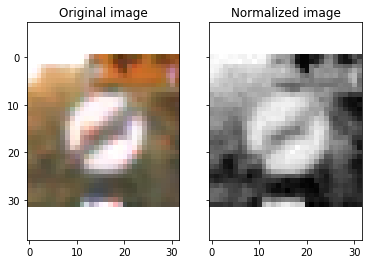

In [6]:
# Preprocessing step: Let's convert the image to RGB, then normalize it 
import cv2

# Let's start with an example
original_image = X_train[120]#[32904]


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)

ax1.imshow(original_image)
ax1.set_title('Original image')

normalized = PreProcess(original_image)

ax2.imshow(normalized.squeeze(), cmap='gray')
ax2.set_title('Normalized image')

# Let's have a look at the preprocessed image mean values
print(np.mean(normalized.squeeze()), np.std(normalized.squeeze()))

plt.show()


### Model Architecture

In [7]:
# Let's start with the LaNet architecture
import tensorflow as tf
from sklearn.utils import shuffle

EPOCHS = 50
BATCH_SIZE = 128

In [8]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    ## First Layer
    # Convolution, Input = 32x32x1, Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation
    conv1 = tf.nn.relu(conv1)
    
    # Max pooling, Input = 28x28x6, Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Dropout to prevent overfitting
    conv1 = tf.nn.dropout(conv1, keep_prob)
    
    ## Second layer
    # Convolution, Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Max pooling, Input = 10x10x16, Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten, Input = 5x5x16, Output = 400.
    fc0   = flatten(conv2)

    # Dropout to prevent overfitting
    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    ## Third layer
    # Fully connected, Input = 400, Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # Activation
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob)
    
    ## Fourth layer
    # Fully connected, Input = 120, Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # Activation
    fc2    = tf.nn.relu(fc2)
    
    # Dropout to prevent overfitting
    fc2    = tf.nn.dropout(fc2, keep_prob)
    
    ## Fifth layer
    # Fully connected, Input = 84, Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

### Train, Validate and Test the Model

In [9]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
# Drop out
keep_prob = tf.placeholder(tf.float32)

In [10]:
rate = 0.00025

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


In [11]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        # Preprocess batch
        batch_x_pp = np.zeros((batch_x.shape[0], 32, 32, 1))
        for i in range(batch_x.shape[0]):
            batch_x_pp[i] = PreProcess(batch_x[i])
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x_pp, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Training the model

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    acc = []
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            # Preprocess batch
            batch_x_pp = np.zeros((batch_x.shape[0], 32, 32, 1))
            for j in range(batch_x.shape[0]):
                batch_x_pp[j] = PreProcess(batch_x[j])
            sess.run(training_operation, feed_dict={x: batch_x_pp, y: batch_y, keep_prob: 0.7})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        acc.append(validation_accuracy)
        print()
        
    saver.save(sess, './finalModel')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.306

EPOCH 2 ...
Validation Accuracy = 0.516

EPOCH 3 ...
Validation Accuracy = 0.636

EPOCH 4 ...
Validation Accuracy = 0.727

EPOCH 5 ...
Validation Accuracy = 0.763

EPOCH 6 ...
Validation Accuracy = 0.779

EPOCH 7 ...
Validation Accuracy = 0.811

EPOCH 8 ...
Validation Accuracy = 0.834

EPOCH 9 ...
Validation Accuracy = 0.840

EPOCH 10 ...
Validation Accuracy = 0.851

EPOCH 11 ...
Validation Accuracy = 0.859

EPOCH 12 ...
Validation Accuracy = 0.868

EPOCH 13 ...
Validation Accuracy = 0.880

EPOCH 14 ...
Validation Accuracy = 0.883

EPOCH 15 ...
Validation Accuracy = 0.891

EPOCH 16 ...
Validation Accuracy = 0.893

EPOCH 17 ...
Validation Accuracy = 0.898

EPOCH 18 ...
Validation Accuracy = 0.895

EPOCH 19 ...
Validation Accuracy = 0.904

EPOCH 20 ...
Validation Accuracy = 0.902

EPOCH 21 ...
Validation Accuracy = 0.905

EPOCH 22 ...
Validation Accuracy = 0.909

EPOCH 23 ...
Validation Accuracy = 0.918

EPOCH 24 ...
Validation Accura

Validation accuracy is above the required threshold. One could spend more time trying different architectures and/or preprocessing techniques, but let's see how the current network performs on new images.

## Step 3: Test a Model on New Images

I have downloaded images of German road signs from real images (for instance using google street view). The included signals are:
- 30 kph speed limit
- 50 kph speed limit
- Yield sign
- Slippery road
- Turn right only

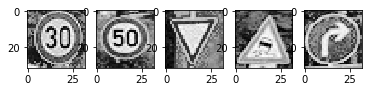

In [13]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# Load images
NEW_IMAGES  = r".\new_images"
ThirtyLimit = os.path.join(NEW_IMAGES, "30.jpg")
FiftyLimit  = os.path.join(NEW_IMAGES, "50.jpg")
Yield       = os.path.join(NEW_IMAGES, "yield.jpg")
Sliperry    = os.path.join(NEW_IMAGES, "slippery.jpg")
TurnRight   = os.path.join(NEW_IMAGES, "turnright.jpg")


# Let's have a look at the images after preprocessing

fig = plt.figure()

plt.subplot(151)
thirty = plt.imread(ThirtyLimit)[:,:,:3]
plt.imshow(PreProcess(thirty)[:,:,0], cmap='gray')

plt.subplot(152)
fifty = plt.imread(FiftyLimit)[:,:,:3]
plt.imshow(PreProcess(fifty)[:,:,0], cmap='gray')

plt.subplot(153)
yield_ = plt.imread(Yield)[:,:,:3]
plt.imshow(PreProcess(yield_)[:,:,0], cmap='gray')

plt.subplot(154)
slip = plt.imread(Sliperry)[:,:,:3]
plt.imshow(PreProcess(slip)[:,:,0], cmap='gray')

plt.subplot(155)
right = plt.imread(TurnRight)[:,:,:3]
plt.imshow(PreProcess(right)[:,:,0], cmap='gray')

plt.show()




### Predict the Sign Type for Each Image

In [14]:
# Feeder for all new images at once
feeder = np.zeros((5,32,32,1))
ground_truth = [1, 2, 13, 23, 33] # Ground truth, based on the signames.csv file
with tf.Session() as sess:    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('finalModel.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    # Set up the feeder
    feeder[0] = PreProcess(thirty)
    feeder[1] = PreProcess(fifty)
    feeder[2] = PreProcess(yield_)
    feeder[3] = PreProcess(slip)
    feeder[4] = PreProcess(right)
    
    classifier_output = sess.run(tf.argmax(logits, 1), feed_dict={x:feeder, keep_prob:1.0})
    
    print(classifier_output)
    


[ 1  2 13 23 33]


### Analyze Performance

In [15]:
# Let's compare the output of the classifier on the new images with the labels
correct_pred = sum([1 for a,b in zip(ground_truth, classifier_output ) if a==b])

accuracy = float(100.0*correct_pred) / len(classifier_output)

print("Accuracy on the new images from the web = {:.1f} %".format(accuracy))

Accuracy on the new images from the web = 100.0 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [16]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
feeder = np.zeros((5,32,32,1))
titles = ["30kph", "50kph", "Yield", "Slippery", "Right Only"]
with tf.Session() as sess:    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('finalModel.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    # Set up the feeder
    feeder[0] = PreProcess(thirty)
    feeder[1] = PreProcess(fifty)
    feeder[2] = PreProcess(yield_)
    feeder[3] = PreProcess(slip)
    feeder[4] = PreProcess(right)
    
    out = sess.run(logits, feed_dict={x:feeder, keep_prob:1.0})
    
    for image, title in zip(out, titles):
        print(title)
        output = sess.run(tf.nn.top_k(tf.nn.softmax(image), 5))
        probs = output[0]
        label = output[1]
        for l,p in zip(label, probs):
            print(l, "with probability %.2f" % p)
        print()

30kph
1 with probability 0.94
2 with probability 0.05
0 with probability 0.00
5 with probability 0.00
6 with probability 0.00

50kph
2 with probability 0.71
5 with probability 0.23
1 with probability 0.03
3 with probability 0.02
4 with probability 0.00

Yield
13 with probability 1.00
35 with probability 0.00
38 with probability 0.00
3 with probability 0.00
12 with probability 0.00

Slippery
23 with probability 0.88
19 with probability 0.10
31 with probability 0.01
21 with probability 0.01
30 with probability 0.00

Right Only
33 with probability 1.00
39 with probability 0.00
37 with probability 0.00
35 with probability 0.00
11 with probability 0.00



### Figure out accuracy on the test catalogue

In [17]:
with tf.Session() as sess:    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('finalModel.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    test_accuracy = evaluate(X_test, y_test)
    print("Accuracy on the test catalogue = {:.3f}".format(test_accuracy))

Accuracy on the test catalogue = 0.919
